### 氫原子光譜繪製

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spe
from matplotlib import cm
%matplotlib widget
plt.rcParams['text.usetex'] = True

In [2]:
class Compact:
    def __init__(self, n=1, l=0, m=0, alpha=0.4):
        self.n = n
        self.l = l
        self.m = m
        self.make2d = True
        self.make3d = True
        self.make_color_bar = True
        self.alpha = alpha
        # 將matplotlib的東西準備好
        plt.style.use("default")
        self.fig = plt.figure(figsize=(10, 4))
        self.fig.tight_layout()
        self.ax = None
        self.ax2d = None

    @staticmethod
    def psi_r(r, n=1, l=0):
        """
        the function is for the following formula, also known as
        The Laguerre polynomials (拉蓋爾多項式)
                    ____________________
                   /   2   3  (n-l-1)!    -r/na0    2r  l    (2l+1)    2r
        R  (r) =  / (-----)  ----------  e       (-----)  · L       (-----)
         nl      √    na0     2n(n+l)!             na0       (n-l+1)  na0
        :param r: radial coordinate 徑向坐標
        :param n: principal quantum number 主量子數, originally set to 1
        :param l: angular momentum quantum number 角動量量子數,
                  originally set to 0
        :return: radial wave function
        """
        # R_nl(r) = 係數 * 拉蓋爾多項式 如上圖
        # 係數(上圖前面根號的部分)
        coeff = np.sqrt((2.0 / n) ** 3 * spe.factorial(n - l - 1) /
                        (n * spe.factorial(n + l) * 2.0))
        # 拉蓋爾多項式(上圖後面的部分)
        laguerre = spe.assoc_laguerre(2.0 * r / n, n - l - 1, 2 * l + 1)
        # 徑向波函數
        return coeff * np.exp(-r / n) * (2.0 * r / n) ** l * laguerre

    @staticmethod
    def psi_ang(phi, theta, l=0, m=0):
        """
        the function is for the following formula, also known as
        Spherical harmonics (球諧函數)

                                     ________________
                                    /  2l+1   (l-m)!               imϕ
        Y  (θ,ϕ) = Θ  (θ) Φ (ϕ) =  / ------- -------- P  (cosθ) · e
         lm         lm     m      √    4π     (l+m)!   lm
        :param phi: azimuthal coordinate 方位角座標
        :param theta: polar coordinate 極座標
        :param l: angular momentum quantum number 角動量量子數,
                  originally set to 0
        :param m: magnetic quantum number 磁量子數, originally set to 0
        :return: angular wave function
        """
        # 直接使用scipy內建special.sph_harm
        return spe.sph_harm(m, l, phi, theta).real

    def set_up(self):
        self.fig.clear()
        total_draw = 2 if self.make2d and self.make3d else \
                     1 if self.make2d or self.make3d else 0
        self.fig.set_size_inches(5 * total_draw, 4)
        # 3d
        if self.make3d:
            self.ax = self.fig.add_subplot(1, total_draw, 1,
                                           projection="3d")
            self.ax.set_zticklabels([])
            self.ax.set_yticklabels([])
            self.ax.set_xticklabels([])
            self.ax.set_box_aspect((1, 1, 1))
            theta, phi = np.linspace(0, 8, 500), \
                         np.linspace(0, 4, 500)
            theta, phi = np.meshgrid(theta, phi)
            y_lm = self.psi_ang(theta, phi, l=self.l, m=self.m)

            x = abs(y_lm) * np.sin(phi) * np.cos(theta)
            y = abs(y_lm) * np.sin(phi) * np.sin(theta)
            z = abs(y_lm) * np.cos(phi)
            lim_max = max((x.max(), y.max(), z.max()))
            lim_min = min((x.min(), y.min(), z.min()))
            self.ax.set_xlim(lim_min, lim_max)
            self.ax.set_xlabel("x", labelpad=-15)
            self.ax.set_ylim(lim_min, lim_max)
            self.ax.set_ylabel("y", labelpad=-15)
            self.ax.set_zlim(lim_min, lim_max)
            self.ax.set_zlabel("z", labelpad=-15)

            p = self.ax.plot_surface(x, y, z, cmap=cm.rainbow,
                                     alpha=self.alpha)
            if self.make_color_bar: plt.colorbar(p, ax=self.ax)

        # 2d
        if self.make2d:
            self.ax2d = self.fig.add_subplot(1, total_draw,
                                             2 if self.make3d else 1)
            self.ax2d.set_yticklabels([])
            self.ax2d.set_xticklabels([])
            self.ax2d.set_aspect("equal")
            limit = 4 * (self.n + self.l)
            x_1d = np.linspace(-limit, limit, 400)
            z_1d = np.linspace(-limit, limit, 400)
            fx, fz = np.meshgrid(x_1d, z_1d)
            r = np.sqrt(fx ** 2 + fz ** 2)
            theta, phi = np.arctan2(np.sqrt(fx ** 2), fz), np.arctan2(0, fx)

            psinlm = np.abs(self.psi_r(r, self.n, self.l) *
                            self.psi_ang(phi, theta, self.l, self.m))
            c = self.ax2d.pcolormesh(fx, fz, psinlm, cmap=cm.magma,
                                     alpha=1)
            if self.make_color_bar: plt.colorbar(c, ax=self.ax2d)
        self.fig.subplots_adjust(top=0.7)
        self.fig.suptitle(
            r"$\psi _{nl} \left( r \right) = "
            r"\sqrt {\left( {\frac{2}{{na_0 }}} \right)^3 "
            r"\frac{{\left( {n - l - 1} \right)!}}"
            r"{{2n\left[ {\left( {n + l} \right)!} \right]}}} "
            r"e^{ - r/na_0 } \left( {\frac{{2r}}{{na_0 }}} \right)^l "
            r"L_{n - l - 1}^{2l + 1}  "
            r"\cdot Y_l^m \left( {\theta ,\phi } \right)$" +
            f"\n(n, l, m) = {(self.n, self.l, self.m)}",
            math_fontfamily="cm", size=20)

    @staticmethod
    def show():
        plt.show()

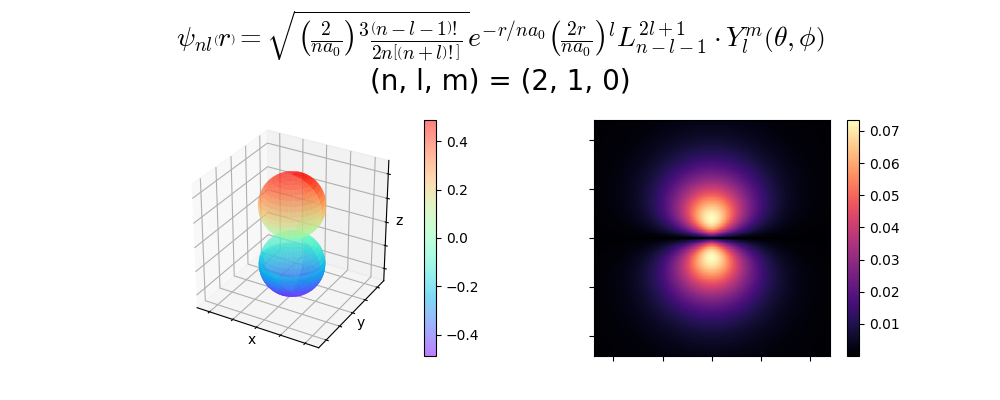

In [3]:
a = Compact()
a.n = 2
a.l = 1
a.m = 0
a.alpha = 0.5  # 透明度
a.set_up()
a.show()

In [4]:
# 電腦卡卡跑這行
plt.clf()